https://podaac.jpl.nasa.gov/dataset/CYGNSS_L3_UC_BERKELEY_WATERMASK_V3.1#

https://podaac.jpl.nasa.gov/dataset/CYGNSS_L3_UC_BERKELEY_WATERMASK_DAILY_V3.2

In [35]:
# pip install earthaccess xarray h5netcdf
import earthaccess as ea

# 1) Log in (opens a device-code prompt) and search
ea.login()


In [36]:
import cftime

In [37]:
# %% ------------------ Setup ------------------
import os
from pathlib import Path
from typing import Tuple, List

import earthaccess as ea
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------ Parameters ------------------
SHORT_NAME = "CYGNSS_L3_UC_BERKELEY_WATERMASK_V3.1"
VERSION    = "3.1"

# Full-range temporal window (broad; server returns only what's available)
TEMPORAL   = ("2016-01-01", "2030-12-31")

# Okavango bbox (min_lon, min_lat, max_lon, max_lat)
OKAV_BBOX = (21.696, -20.223, 24.103, -18.221)

# Output
BASE_OUT   = Path("../data/cygnss_okavango_full")
CROPS_DIR  = BASE_OUT / "crops_nc"
MERGED_NC  = BASE_OUT / "cygnss_okavango_full_merged.nc"
BASE_OUT.mkdir(parents=True, exist_ok=True)
CROPS_DIR.mkdir(parents=True, exist_ok=True)

# ------------------ Helpers ------------------
def find_lat_lon_names(ds: xr.Dataset) -> Tuple[str, str]:
    lat = next(n for n in ds.dims if n.lower() in ("lat","latitude","y"))
    lon = next(n for n in ds.dims if n.lower() in ("lon","longitude","x"))
    return lat, lon



def pick_var_with_latlon(ds: xr.Dataset, lat: str, lon: str) -> str:
    preferred = [v for v in ds.data_vars if ("mask" in v.lower()) or ("water" in v.lower())]
    for v in preferred:
        if {lat, lon}.issubset(ds[v].dims): return v
    for v in ds.data_vars:
        if {lat, lon}.issubset(ds[v].dims): return v
    return list(ds.data_vars)[0]

def aoi_lat_slice(ds: xr.Dataset, lat_name: str, bbox) -> slice:
    lat_vals = ds[lat_name].values
    south, north = bbox[1], bbox[3]
    return slice(north, south) if (lat_vals[0] > lat_vals[-1]) else slice(south, north)

def weights_coslat(lat_vals: np.ndarray) -> np.ndarray:
    return np.cos(np.deg2rad(lat_vals))

def decode_months_since(ds: xr.Dataset, time_name: str = "time") -> pd.DatetimeIndex:
    """
    Convert CF-like 'months since YYYY-MM-DD ...' to pandas datetime without cftime.
    Keeps the same length/ordering as ds[time_name].
    """
    if time_name not in ds:
        raise ValueError("No time coordinate found to decode.")
    t = ds[time_name]
    units = t.attrs.get("units", "")
    # Expect e.g., 'months since 2018-08-01 00:30:00.000000000'
    if "months since" not in units:
        # Fallback: try xarray decode if possible
        try:
            _ = xr.decode_cf(ds)[time_name].to_index()
        except Exception:
            return pd.RangeIndex(len(t))  # unlabeled
        else:
            return xr.decode_cf(ds)[time_name].to_index()

    base_str = units.split("months since", 1)[1].strip().split()[0]  # 'YYYY-MM-DD'
    base = pd.Timestamp(base_str)
    offs = pd.to_numeric(t.values)  # months as integers/floats
    # Build datetime by adding month offsets
    idx = pd.DatetimeIndex([base + pd.DateOffset(months=int(m)) for m in offs])
    return idx

# ------------------ 1) Search (full period) & open authenticated ------------------
ea.login()
results = ea.search_data(
    short_name=SHORT_NAME,
    version=VERSION,
    temporal=TEMPORAL,
    # spatial filter is optional (files are global), but harmless:
    # bounding_box=OKAV_BBOX,
)
files = ea.open(results)  # authenticated file-like objects

print(f"Found {len(files)} monthly files across the full record (server may paginate).")

import re

def month_from_granule(gran) -> str | None:
    """
    Return 'YYYY-MM' by parsing the granule's name/id/URL.
    No temporal metadata, no time decoding.
    """
    # Try producer_granule_id
    name = getattr(gran, "producer_granule_id", None)
    if not isinstance(name, str):
        # Try UMM (if present)
        umm = getattr(gran, "umm", None)
        if isinstance(umm, dict):
            name = umm.get("DataGranule", {}).get("ProducerGranuleId")
    # Try the first link as a last-resort string
    if not isinstance(name, str):
        try:
            links = gran.data_links(access="external") or gran.data_links(access="direct") or []
            if links:
                name = str(links[0])
        except Exception:
            name = None

    if isinstance(name, str):
        m = re.search(r"(\d{4})[-_](\d{2})", name)
        if m:
            y, mo = int(m.group(1)), int(m.group(2))
            return f"{y:04d}-{mo:02d}"
    return None


def crop_and_save_nc(fobj, granule, idx: int, bbox=OKAV_BBOX) -> Path:
    # Open WITHOUT time decoding
    for engine in ("netcdf4", "h5netcdf"):
        try:
            ds = xr.open_dataset(fobj, engine=engine, decode_times=False, mask_and_scale=True)
            break
        except Exception:
            if engine == "h5netcdf":
                raise

    # Get YYYY-MM from filename/id/URL; else use idx
    stamp = month_from_granule(granule)
    if not isinstance(stamp, str) or not stamp:
        stamp = f"{idx:04d}"  # simple numeric fallback, no formatting of non-strings

    # Crop
    lat, lon = find_lat_lon_names(ds)
    lat_slice = aoi_lat_slice(ds, lat, bbox)
    sub = ds.sel({lon: slice(bbox[0], bbox[2]), lat: lat_slice})

    # Write compressed NetCDF named by month
    out_nc = CROPS_DIR / f"okav_{stamp}.nc"
    if out_nc.exists():  # avoid overwriting duplicates
        k = 1
        while (CROPS_DIR / f"okav_{stamp}_{k}.nc").exists():
            k += 1
        out_nc = CROPS_DIR / f"okav_{stamp}_{k}.nc"

    enc = {v: {"zlib": True, "complevel": 4} for v in sub.data_vars}
    sub.to_netcdf(out_nc, encoding=enc)
    ds.close()
    return out_nc

written_nc: List[Path] = []
files = ea.open(results)  # authenticated file-like objects

for i, (fobj, gran) in enumerate(zip(files, results)):
    try:
        p = crop_and_save_nc(fobj, gran, i)
        print("Wrote:", p.name)
        written_nc.append(p)
    except Exception as e:
        print("Skipped one ->", e)

# Sort by filename so order is chronological when YYYY-MM worked
written_nc = sorted(written_nc, key=lambda p: p.name)
print(f"Per-month crops written: {len(written_nc)} -> {CROPS_DIR}")



QUEUEING TASKS | :   0%|          | 0/87 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/87 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/87 [00:00<?, ?it/s]

Found 87 monthly files across the full record (server may paginate).


QUEUEING TASKS | :   0%|          | 0/87 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/87 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/87 [00:00<?, ?it/s]

Wrote: okav_2018-08_3.nc
Wrote: okav_2018-09_3.nc
Wrote: okav_2018-10_3.nc
Wrote: okav_2018-11_3.nc
Wrote: okav_2018-12_3.nc
Wrote: okav_2019-01_3.nc
Wrote: okav_2019-02_3.nc
Wrote: okav_2019-03_3.nc
Wrote: okav_2019-04_3.nc
Wrote: okav_2019-05_3.nc
Wrote: okav_2019-06_3.nc
Wrote: okav_2019-07_3.nc
Wrote: okav_2019-08_3.nc
Wrote: okav_2019-09_3.nc
Wrote: okav_2019-10_3.nc
Wrote: okav_2019-11_3.nc
Wrote: okav_2019-12_3.nc
Wrote: okav_2020-01_3.nc
Wrote: okav_2020-02_3.nc
Wrote: okav_2020-03_3.nc
Wrote: okav_2020-04_3.nc
Wrote: okav_2020-05_3.nc
Wrote: okav_2020-06_3.nc
Wrote: okav_2020-07_3.nc
Wrote: okav_2020-08_3.nc
Wrote: okav_2020-09_3.nc
Wrote: okav_2020-10_3.nc
Wrote: okav_2020-11_3.nc
Wrote: okav_2020-12_3.nc
Wrote: okav_2021-01_3.nc
Wrote: okav_2021-02_3.nc
Wrote: okav_2021-03_3.nc
Wrote: okav_2021-04_3.nc
Wrote: okav_2021-05_3.nc
Wrote: okav_2021-06_3.nc
Wrote: okav_2021-07_3.nc
Wrote: okav_2021-08_3.nc
Wrote: okav_2021-09_3.nc
Wrote: okav_2021-10_3.nc
Wrote: okav_2021-11_3.nc


QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

Trial file written: ../data/cygnss_okavango_full/crops_nc/okav_2023-08_6.nc


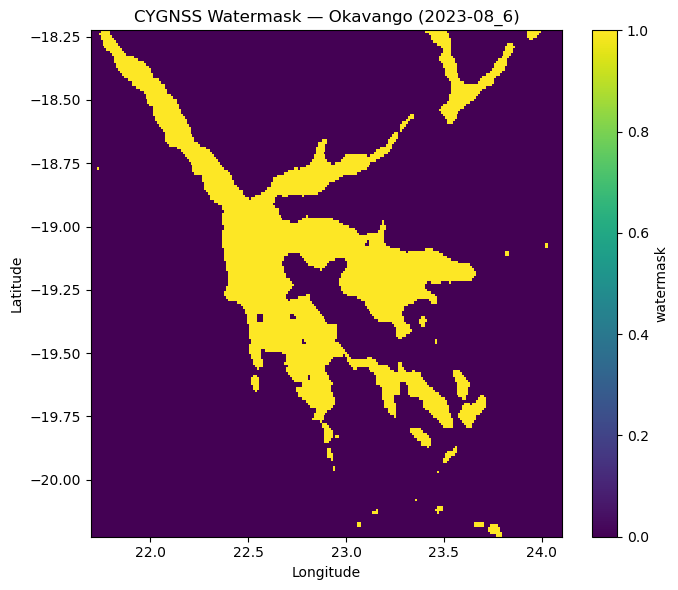

In [38]:
# --- One-month trial (e.g., Aug 2023) ---
TRIAL_RANGE = ("2023-08-01", "2023-09-01")  # end is exclusive

ea.login()
trial_results = ea.search_data(
    short_name=SHORT_NAME,
    version=VERSION,
    temporal=TRIAL_RANGE,
)
assert trial_results, "No granules found for the trial month."

trial_files = ea.open(trial_results)

# Pass BOTH the file-like object and its granule to keep YYYY-MM naming
trial_path = crop_and_save_nc(trial_files[0], trial_results[0], idx=0, bbox=OKAV_BBOX)
print("Trial file written:", trial_path)

# visualize
ds_trial = xr.open_dataset(trial_path, decode_times=False)
lat, lon = find_lat_lon_names(ds_trial)
varname  = pick_var_with_latlon(ds_trial, lat, lon)
da = ds_trial[varname]
tdim = next((d for d in da.dims if d.lower().startswith("time")), None)
if tdim is not None:
    da = da.isel({tdim: 0}).squeeze(drop=True)

plt.figure(figsize=(7,6))
plt.pcolormesh(ds_trial[lon], ds_trial[lat], da, shading="auto")
plt.colorbar(label=varname)
plt.title(f"CYGNSS Watermask — Okavango ({trial_path.stem.replace('okav_', '')})")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.tight_layout(); plt.show()
ds_trial.close()


In [39]:
from pathlib import Path
import xarray as xr
import rioxarray  # ensures .rio accessor
import geopandas as gpd
from shapely.geometry import mapping, shape
import ee, json
ee.Initialize()

# Load + dissolve the asset to a single geometry
fc = ee.FeatureCollection("projects/ee-okavango/assets/shapes/okavango_outline_20241031")
geom_ee = ee.Geometry(fc.geometry())                 # dissolve to one
geom_geojson = geom_ee.getInfo()                     # GeoJSON-like dict
geom = mapping(shape(geom_geojson))                  # shapely mapping (lon/lat)


CROPS_DIR = Path("../data/cygnss_okavango_full/crops_nc")      # your existing monthly crops
CLIPPED_DIR = Path("../data/cygnss_okavango_full/crops_nc_clip")
CLIPPED_DIR.mkdir(parents=True, exist_ok=True)

# Load polygon (assumed EPSG:4326 lon/lat)
# gdf = gpd.read_file("okavango_outline_20241031.geojson")
# geom = mapping(gdf.to_crs("EPSG:4326").unary_union)  

def clip_nc(in_path: Path, out_path: Path):
    ds = xr.open_dataset(in_path, decode_times=False)

    # tell rioxarray which dims are spatial + CRS
    ds = ds.rio.write_crs("EPSG:4326")\
             .rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=False)

    # clip each data variable that has lat/lon dims
    clipped_vars = []
    for v in ds.data_vars:
        dv = ds[v]
        if "lat" in dv.dims and "lon" in dv.dims:
            cv = dv.rio.clip([geom], crs="EPSG:4326", drop=True)
            clipped_vars.append(cv.to_dataset(name=v))
        else:
            # non-spatial vars pass through unchanged
            clipped_vars.append(dv.to_dataset(name=v))

    ds_clip = xr.merge(clipped_vars)

    # light compression
    enc = {v: {"zlib": True, "complevel": 4} for v in ds_clip.data_vars}
    ds_clip.to_netcdf(out_path, encoding=enc)
    ds.close()

# batch
for p in sorted(CROPS_DIR.glob("okav_*.nc")):
    out = CLIPPED_DIR / p.name.replace(".nc", ".nc")
    clip_nc(p, out)
    print("Wrote", out)


Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2018-08.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2018-08_1.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2018-08_2.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2018-08_3.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2018-09.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2018-09_1.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2018-09_2.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2018-09_3.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2018-10.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2018-10_1.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2018-10_2.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2018-10_3.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2018-11.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2018-11_1.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2018-11_2.nc
Wro

Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2021-04.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2021-04_1.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2021-04_2.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2021-04_3.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2021-05.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2021-05_1.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2021-05_2.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2021-05_3.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2021-06.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2021-06_1.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2021-06_2.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2021-06_3.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2021-07.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2021-07_1.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2021-07_2.nc
Wro

Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2023-10_1.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2023-10_2.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2023-10_3.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2023-11.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2023-11_1.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2023-11_2.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2023-11_3.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2023-12.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2023-12_1.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2023-12_2.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2023-12_3.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2024-01.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2024-01_1.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2024-01_2.nc
Wrote ../data/cygnss_okavango_full/crops_nc_clip/okav_2024-01_3.nc
W

## Visualize

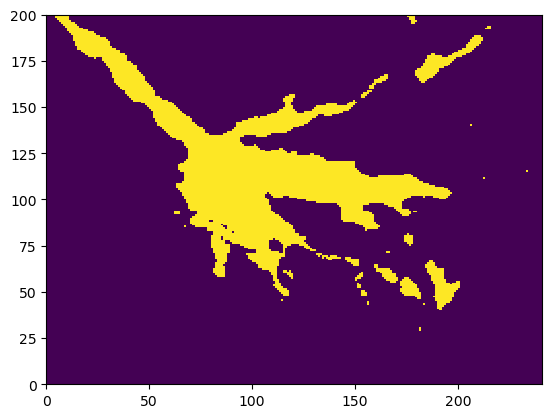

In [40]:
import matplotlib.pyplot as plt
import xarray as xr
# ds = xr.open_dataset('cygnss_okavango_full/crops_nc/okav_2025-07.nc', decode_times=False)
# plt.imshow(ds['watermask'])

ds = xr.open_dataset('../data/cygnss_okavango_full/crops_nc/okav_2025-05.nc', decode_times=False)
plt.pcolormesh(ds['watermask'])

In [41]:
# ds = xr.open_dataset('../data/cygnss_okavango_full/crops_nc/okav_2025-06.nc', decode_times=False)
# plt.pcolormesh(ds['watermask'])

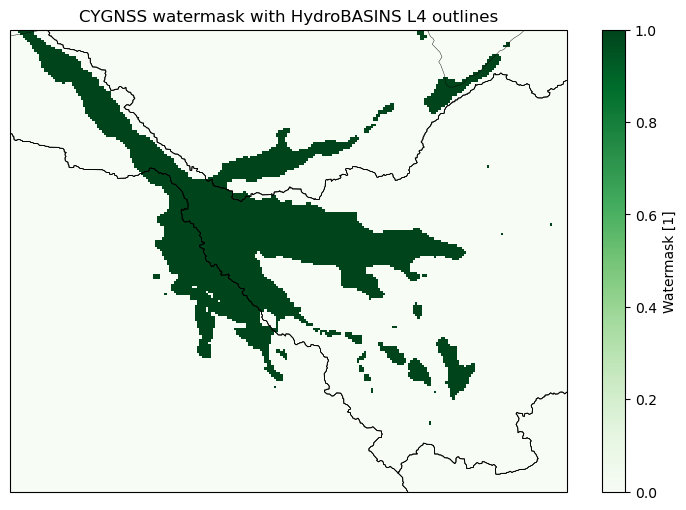

In [42]:
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import ee
import geemap

# ---- load your raster ----
ds = xr.open_dataset("../data/cygnss_okavango_full/crops_nc/okav_2025-05.nc", decode_times=False)
wm = ds["watermask"].squeeze()   # handles a singleton time dim if present

# ---- find lat/lon coord names (adjust if yours differ) ----
# Common cases: ('lat','lon') or ('latitude','longitude')
lat_name = "lat" if "lat" in wm.coords else ("latitude" if "latitude" in wm.coords else None)
lon_name = "lon" if "lon" in wm.coords else ("longitude" if "longitude" in wm.coords else None)

if lat_name is None or lon_name is None:
    raise ValueError(
        "Your DataArray has no lat/lon coordinates. "
        "To plot on a map / intersect basins you must attach georeferencing "
        "(lat/lon coords or an affine transform)."
    )

lat = wm[lat_name]
lon = wm[lon_name]

# Ensure lat is increasing for clean plotting (optional but usually helpful)
if lat.ndim == 1 and lat.size > 1 and float(lat[1] - lat[0]) < 0:
    wm = wm.sortby(lat_name)
    lat = wm[lat_name]

# ---- EE init ----
# First time in a new environment you may need: ee.Authenticate()
ee.Initialize()

# ROI = raster bounds
roi = ee.Geometry.Rectangle([float(lon.min()), float(lat.min()), 
                             float(lon.max()), float(lat.max())])

basins = (
    ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_4")
    .filterBounds(roi)
)

# Pull basin geometries to local for plotting (keep ROI tight!)
gdf = geemap.ee_to_gdf(basins)  # GeoDataFrame in EPSG:4326

# ---- plot ----
fig, ax = plt.subplots(figsize=(9, 6), 
                       subplot_kw={"projection": ccrs.PlateCarree()})

# Let xarray drive pcolormesh with proper coords
wm.plot.pcolormesh(
    ax=ax,
    x=lon_name, y=lat_name,
    transform=ccrs.PlateCarree(),
    add_colorbar=True, cmap = 'Greens'
)

ax.set_extent([float(lon.min()), float(lon.max()), 
               float(lat.min()), float(lat.max())], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=0, facecolor="none")
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.coastlines(linewidth=0.3)

# Basin outlines
ax.add_geometries(
    gdf.geometry,
    crs=ccrs.PlateCarree(),
    facecolor="none",
    edgecolor="black",
    linewidth=0.6,
    zorder=3
)

ax.set_title("CYGNSS watermask with HydroBASINS L4 outlines")
plt.show()


In [43]:
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import ee
import geemap

# ---- load your raster ----
ds = xr.open_dataset("../data/cygnss_okavango_full/crops_nc/okav_2025-05.nc", decode_times=False)
wm = ds["watermask"].squeeze()

# ---- find lat/lon coord names ----
lat_name = "lat" if "lat" in wm.coords else ("latitude" if "latitude" in wm.coords else None)
lon_name = "lon" if "lon" in wm.coords else ("longitude" if "longitude" in wm.coords else None)
if lat_name is None or lon_name is None:
    raise ValueError("No lat/lon coords found on watermask; need georeferencing to map/clip basins.")

lat = wm[lat_name]
lon = wm[lon_name]

# Ensure lat is increasing (optional but helps)
if lat.ndim == 1 and lat.size > 1 and float(lat[1] - lat[0]) < 0:
    wm = wm.sortby(lat_name)
    lat = wm[lat_name]

# ---- EE init ----
# ee.Authenticate()  # if needed
ee.Initialize()

# ROI = raster bounds
roi = ee.Geometry.Rectangle([float(lon.min()), float(lat.min()),
                             float(lon.max()), float(lat.max())])

basins = (ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_4")
          .filterBounds(roi))

# ---- split basins with your line ----
split_line = ee.Geometry.LineString([
    [22.32482333930892, -18.937191233006317],
    [22.496572420605283, -18.827987094560754],
])

buffer_m = 30  # thin cutter; 10–100 m typically fine
cutter = split_line.buffer(buffer_m)

def split_basins_with_line(fc, cutter_geom):
    """Return a FeatureCollection where basins are split by a buffered line cutter."""
    def _split_one(f, acc):
        f = ee.Feature(f)
        acc = ee.List(acc)

        g = f.geometry()

        cut = ee.Geometry(ee.Algorithms.If(
            g.intersects(cutter_geom, 1),
            g.difference(cutter_geom, 1),
            g
        ))

        parts = cut.geometries()
        n = parts.length()

        # If multiple parts, emit one feature per part; else keep original feature
        out = ee.List(ee.Algorithms.If(
            n.gt(1),
            ee.List.sequence(0, n.subtract(1)).map(lambda i: ee.Feature(ee.Geometry(parts.get(i)))
                                                  .copyProperties(f)
                                                  .set({
                                                      "split_from": f.get("HYBAS_ID"),
                                                      "split_i": ee.Number(i),
                                                  })),
            ee.List([f])
        ))

        return acc.cat(out)

    feat_list = ee.List(fc.iterate(_split_one, ee.List([])))
    return ee.FeatureCollection(feat_list)

basins_split = split_basins_with_line(basins, cutter)

# Pull split basin geometries to local for plotting
gdf_split = geemap.ee_to_gdf(basins_split)


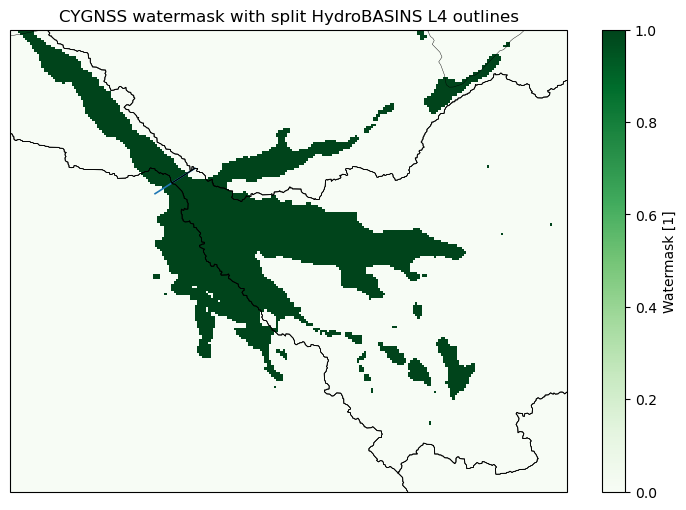

In [44]:

# ---- plot ----
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={"projection": ccrs.PlateCarree()})

wm.plot.pcolormesh(
    ax=ax,
    x=lon_name, y=lat_name,
    transform=ccrs.PlateCarree(),
    add_colorbar=True,
    cmap="Greens",
)

ax.set_extent([float(lon.min()), float(lon.max()),
               float(lat.min()), float(lat.max())], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=0, facecolor="none")
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.coastlines(linewidth=0.3)

# Split-basin outlines
ax.add_geometries(
    gdf_split.geometry,
    crs=ccrs.PlateCarree(),
    facecolor="none",
    edgecolor="black",
    linewidth=0.6,
    zorder=3
)

# Optional: show the split line too
ax.plot(
    [22.32482333930892, 22.496572420605283],
    [-18.937191233006317, -18.827987094560754],
    transform=ccrs.PlateCarree(),
    linewidth=1.2,
)

ax.set_title("CYGNSS watermask with split HydroBASINS L4 outlines")
plt.show()


In [45]:
import pandas as pd

# Choose what you want the label to be.
# HydroBASINS usually has HYBAS_ID, and often PFAF_ID. Use whichever you prefer.
base_id = "PFAF_ID" if "PFAF_ID" in gdf_split.columns else "HYBAS_ID"

gdf_split = gdf_split.to_crs("EPSG:4326").copy()

# If you split basins, label each part distinctly with split_i when present
if "split_i" in gdf_split.columns:
    gdf_split["basin_label"] = gdf_split.apply(
        lambda r: f"{int(r[base_id])}_{int(r['split_i'])}" if pd.notna(r["split_i"]) else f"{int(r[base_id])}",
        axis=1,
    )
else:
    gdf_split["basin_label"] = gdf_split[base_id].astype(int).astype(str)
import regionmask
import numpy as np

regions = regionmask.Regions(
    outlines=list(gdf_split.geometry),
    numbers=list(range(len(gdf_split))),
    names=list(gdf_split["basin_label"]),
    name="hybas4_split",
)
regions

<regionmask.Regions 'hybas4_split'>
overlap:  None

Regions:
0 r0 1228_0
1 r1 1228_1
2 r2   1293
3 r3 1295_0
4 r4 1295_1
5 r5 1295_2
6 r6   1294

[7 regions]

In [46]:

# # basin mask on the grid only (no time); new regionmask API
# lon_grid = wet[lon_name]
# lat_grid = wet[lat_name]
# if "time" in lon_grid.dims: lon_grid = lon_grid.isel(time=0)
# if "time" in lat_grid.dims: lat_grid = lat_grid.isel(time=0)

# basin_mask = regions.mask(lon_grid, lat_grid)
# basin_mask.name = "basin"

# # inundated area (km^2) per basin over time
# wet_area = wet.astype("float32") * cell_area
# inund_m2  = wet_area.groupby(basin_mask).sum(dim='stacked_lat_lon', skipna=True)
# inund_km2 = inund_m2 / 1e6

# # Map basin integer codes -> basin_label
# id_map = dict(enumerate(regions.names))

# df = inund_km2.to_dataframe("area_km2").reset_index()
# df["basin_label"] = df["basin"].map(id_map)

# # # Wide table with labeled columns (legend will now show labels)
# ts = df.pivot(index="time", columns=["basin_label","basin"], values="area_km2").sort_index()
# ts.plot()

In [47]:
# --- Put it all together: (1) build time stack, (2) compute inundated area vs time per basin,
#     (3) plot timeseries with basin labels, (4) plot a map with basin outlines + labels clipped
#     to the CYGNSS image footprint.

from pathlib import Path
import re
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patheffects as pe

import regionmask
from shapely.geometry import box

# -------------------------------------------------------------------
# 0) Inputs
# -------------------------------------------------------------------
nc_dir = Path("../data/cygnss_okavango_full/crops_nc")
files = sorted(nc_dir.glob("okav_*.nc"))

# If you already created gdf_split earlier, leave it as-is.
# Otherwise you need to define/produce gdf_split before running the basin steps below.
# gdf_split should be a GeoDataFrame in EPSG:4326 with a polygon geometry column.

# Controls
topN = 10                    # plot top N basins by mean area
map_time = None              # e.g., "2025-05-15" or None to use last time
water_is_value = 1           # watermask encoding (change if needed)

# -------------------------------------------------------------------
# 1) Open the monthly stack (work around "months since ..." decode issue)
# -------------------------------------------------------------------
def month_from_fname(p: Path) -> pd.Timestamp:
    m = re.search(r"okav_(\d{4})-(\d{2})", p.stem)
    if m is None:
        raise ValueError(f"Could not parse YYYY-MM from filename: {p.name}")
    y, mo = map(int, m.groups())
    return pd.Timestamp(y, mo, 15)  # mid-month label

times = pd.DatetimeIndex([month_from_fname(p) for p in files], name="time")

def preprocess(ds):
    # each file has one timestep; drop the problematic encoded time var/coord
    if "time" in ds.dims:
        ds = ds.isel(time=0, drop=True)
    ds = ds.drop_vars("time", errors="ignore")
    return ds

ds = xr.open_mfdataset(
    files,
    combine="nested",
    concat_dim="time",
    preprocess=preprocess,
    decode_times=False,
)
ds = ds.assign_coords(time=("time", times))

wm = ds["watermask"]  # dims should be (time, lat, lon) or similar

# -------------------------------------------------------------------
# 2) Lat/Lon names + ensure lat increasing
# -------------------------------------------------------------------
lat_name = "lat" if "lat" in wm.coords else ("latitude" if "latitude" in wm.coords else None)
lon_name = "lon" if "lon" in wm.coords else ("longitude" if "longitude" in wm.coords else None)
if lat_name is None or lon_name is None:
    raise ValueError("Need lat/lon coords on watermask for mapping + basin stats.")

if wm[lat_name].ndim == 1 and wm[lat_name].size > 1 and float(wm[lat_name][1] - wm[lat_name][0]) < 0:
    wm = wm.sortby(lat_name)

# -------------------------------------------------------------------
# 3) Study-area polygon from CYGNSS footprint (for clipped label points)
# -------------------------------------------------------------------
lon_min = float(wm[lon_name].min())
lon_max = float(wm[lon_name].max())
lat_min = float(wm[lat_name].min())
lat_max = float(wm[lat_name].max())
study_area = box(lon_min, lat_min, lon_max, lat_max)  # EPSG:4326

# -------------------------------------------------------------------
# 4) Make basin labels (legend + map text)
# -------------------------------------------------------------------
# Prefer a stable id column if present
base_id = "PFAF_ID" if "PFAF_ID" in gdf_split.columns else "HYBAS_ID"

gdf_split = gdf_split.to_crs("EPSG:4326").copy()
if "split_i" in gdf_split.columns:
    gdf_split["basin_label"] = gdf_split.apply(
        lambda r: f"{int(r[base_id])}_{int(r['split_i'])}" if pd.notna(r["split_i"]) else f"{int(r[base_id])}",
        axis=1,
    )
else:
    gdf_split["basin_label"] = gdf_split[base_id].astype(int).astype(str) 
    
# -------------------------------------------------------------------
# 5) Regionmask regions + basin mask on the grid (no time)
# -------------------------------------------------------------------
regions = regionmask.Regions(
    outlines=list(gdf_split.geometry),
    numbers=list(range(len(gdf_split))),
    names=list(gdf_split["basin_label"]),
    name="hybas4_split",
)

# Wet mask as boolean (avoid uint8 casting warnings)
wet = (wm == water_is_value).fillna(False)

lon_grid = wet[lon_name]
lat_grid = wet[lat_name]
if "time" in lon_grid.dims: lon_grid = lon_grid.isel(time=0)
if "time" in lat_grid.dims: lat_grid = lat_grid.isel(time=0)

basin_mask = regions.mask(lon_grid, lat_grid)
basin_mask.name = "basin"

# -------------------------------------------------------------------
# 6) Pixel area (m^2) for regular 1D lat/lon grid + inundated area time series
# -------------------------------------------------------------------
R = 6371000.0
lat = wet[lat_name].values
lon = wet[lon_name].values

dlat = np.deg2rad(np.abs(np.diff(lat)).mean())
dlon = np.deg2rad(np.abs(np.diff(lon)).mean())
lat_rad = np.deg2rad(lat)

cell_area_1d = (R**2) * dlat * dlon * np.cos(lat_rad)  # (lat,)
cell_area = xr.DataArray(
    cell_area_1d,
    coords={lat_name: wet[lat_name]},
    dims=(lat_name,),
).broadcast_like(wet.isel(time=0))

wet_area = wet.astype("float32") * cell_area
inund_m2  = wet_area.groupby(basin_mask).sum(dim='stacked_lat_lon', skipna=True)
inund_km2 = inund_m2 / 1e6

# Basin integer codes -> basin_label
id_map = dict(enumerate(regions.names))

df = inund_km2.to_dataframe("area_km2").reset_index()
df["basin_label"] = df["basin"].map(id_map)

ts = df.pivot(index="time", columns="basin_label", values="area_km2").sort_index()

# -------------------------------------------------------------------
#  Plot a map for one month with outlines + labels clipped to the CYGNSS footprint
# -------------------------------------------------------------------
if map_time is None:
    tsel = wm["time"].values[-1]
else:
    tsel = np.datetime64(pd.Timestamp(map_time))

wm_map = wm.sel(time=tsel)

/Users/octaviacrompton/anaconda3/envs/ee-map/lib/python3.11/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
# -------------------------------------------------------------------
#  Plot a map for one month with outlines + labels clipped to the CYGNSS footprint
# -------------------------------------------------------------------
if map_time is None:
    tsel = wm["time"].values[-1]
else:
    tsel = np.datetime64(pd.Timestamp(map_time))

wm_map = wm.sel(time=tsel, drop=True)

# (optional) if you ever get TopologyException during intersection:
# gdf_split["geometry"] = gdf_split.geometry.make_valid()  # shapely>=2
# or fallback:
# gdf_split["geometry"] = gdf_split.geometry.buffer(0)

fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={"projection": ccrs.PlateCarree()})

wm_map.plot.pcolormesh(
    ax=ax,
    x=lon_name, y=lat_name,
    transform=ccrs.PlateCarree(),
    add_colorbar=True,
    cmap="Greens",
)

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=0, facecolor="none")
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.coastlines(linewidth=0.3)

# basin outlines
ax.add_geometries(
    gdf_split.geometry,
    crs=ccrs.PlateCarree(),
    facecolor="none",
    edgecolor="black",
    linewidth=0.6,
    zorder=3
)

# label only top basins
gdf_label = gdf_split[gdf_split["basin_label"].isin(top_cols)].copy()

def label_point_clipped(geom, clip_poly):
    g = geom.intersection(clip_poly)
    if g.is_empty:
        return None
    p = g.centroid
    if not g.contains(p):
        p = g.representative_point()
    return p

for _, r in gdf_label.iterrows():
    p = label_point_clipped(r.geometry, study_area)
    if p is None:
        continue
    ax.text(
        p.x, p.y, r["basin_label"],
        transform=ccrs.PlateCarree(),
        ha="center", va="center",
        fontsize=8,
        zorder=10,
        path_effects=[pe.withStroke(linewidth=2, foreground="white")]
    )

ax.set_title(f"CYGNSS watermask + basins — {pd.Timestamp(tsel).strftime('%Y-%m')}")
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# watermask
wm_map.plot.pcolormesh(
    ax=ax,
    x=lon_name, y=lat_name,
    transform=ccrs.PlateCarree(),
    add_colorbar=True,
    cmap="Greens",
)

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=0, facecolor="none")
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.coastlines(linewidth=0.3)

# basin outlines (all)
ax.add_geometries(
    gdf_split.geometry,
    crs=ccrs.PlateCarree(),
    facecolor="none",
    edgecolor="black",
    linewidth=0.6,
    zorder=3
)

# labels (only top N to avoid clutter; change to gdf_split for all)
gdf_label = gdf_split[gdf_split["basin_label"].isin(top_cols)].copy()

def label_point_clipped(geom, clip_poly):
    g = geom.intersection(clip_poly)
    if g.is_empty:
        return None
    p = g.centroid
    if not g.contains(p):
        p = g.representative_point()
    return p

for _, r in gdf_label.iterrows():
    p = label_point_clipped(r.geometry, study_area)
    if p is None:
        continue
    ax.text(
        p.x, p.y, r["basin_label"],
        transform=ccrs.PlateCarree(),
        ha="center", va="center",
        fontsize=8,
        zorder=10,
        path_effects=[pe.withStroke(linewidth=2, foreground="white")]
    )

ax.set_title(f"CYGNSS watermask + basins  — {pd.Timestamp(tsel).strftime('%Y-%m')}")
plt.show()


In [ ]:
from pathlib import Path
import re
import pandas as pd
import xarray as xr

nc_dir = Path("../data/cygnss_okavango_full/crops_nc")
files = sorted(nc_dir.glob("okav_*.nc"))

def month_from_fname(p: Path) -> pd.Timestamp:
    m = re.search(r"okav_(\d{4})-(\d{2})", p.stem)
    if m is None:
        raise ValueError(f"Could not parse YYYY-MM from filename: {p.name}")
    y, mo = map(int, m.groups())
    return pd.Timestamp(y, mo, 15)  # mid-month label (pick 1 or 15; just be consistent)

times = pd.DatetimeIndex([month_from_fname(p) for p in files], name="time")

def preprocess(ds):
    # kill the problematic 'time' coordinate coming from the file
    if "time" in ds.dims:
        ds = ds.isel(time=0, drop=True)   # each file has 1 timestep
    ds = ds.drop_vars("time", errors="ignore")  # in case time is a coord var
    return ds

ds = xr.open_mfdataset(
    files,
    combine="nested",
    concat_dim="time",
    preprocess=preprocess,
    decode_times=False,
)

ds = ds.assign_coords(time=("time", times))
wm = ds["watermask"]

import numpy as np
import regionmask
import matplotlib.pyplot as plt

# ---- coord names ----
lat_name = "lat" if "lat" in wm.coords else ("latitude" if "latitude" in wm.coords else None)
lon_name = "lon" if "lon" in wm.coords else ("longitude" if "longitude" in wm.coords else None)
if lat_name is None or lon_name is None:
    raise ValueError("Need lat/lon coords on watermask to compute area + do basin stats.")

# Ensure lat increasing
if wm[lat_name].ndim == 1 and wm[lat_name].size > 1 and float(wm[lat_name][1] - wm[lat_name][0]) < 0:
    wm = wm.sortby(lat_name)

# 0/1 wet mask (edit if your encoding differs)
wet = (wm == 1).fillna(0).astype("uint8")

# ---- pixel area (m^2) for regular lat/lon grid ----
R = 6371000.0
lat = wet[lat_name].values
lon = wet[lon_name].values

dlat = np.deg2rad(np.abs(np.diff(lat)).mean())
dlon = np.deg2rad(np.abs(np.diff(lon)).mean())
lat_rad = np.deg2rad(lat)

cell_area_1d = (R**2) * dlat * dlon * np.cos(lat_rad)  # (lat,)
cell_area = xr.DataArray(
    cell_area_1d,
    coords={lat_name: wet[lat_name]},
    dims=(lat_name,),
).broadcast_like(wet.isel(time=0))

# ---- basin mask from polygons ----
gdf_split = gdf_split.to_crs("EPSG:4326").copy()
gdf_split["basin_id"] = gdf_split.get("basin_id", gdf_split["HYBAS_ID"].astype(int).astype(str))


# --- 1) Rename basins (edit the right-hand strings to your preferred names) ---
name_map = {
    "1295_1": "Panhandle",
    "1295_0": "Panhandle",
    "1228_1": "Eastern panhandle",
    "1295_2": "Eastern Delta",
    "1294":   "Western Delta",
    "1293":   "Outflow",
}

# Keep a fallback label if something isn't mapped
gdf_split["basin_name"] = gdf_split["basin_label"].map(name_map).fillna(gdf_split["basin_label"])

# Rename time-series columns so the legend shows names
ts_named = ts.drop(['1295_0', '1293'], axis = 1).rename(columns=name_map)
ts_named.head()
ts_named['month'] = ts_named.index.month

In [ ]:
((ts_named.drop(['month'], axis = 1) )).plot(figsize = (14,4))
plt.legend()

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module=r"seaborn\..*")


import seaborn as sns
sns.lineplot(data=ts_named, x = 'month', y = 'Eastern Delta' , marker = 'o', linestyle = ':');
sns.lineplot(data=ts_named, x = 'month', y = 'Western Delta' , marker = 'o', linestyle = ':');
sns.lineplot(data=ts_named, x = 'month', y = 'Eastern panhandle' , marker = 'o', linestyle = ':');


In [ ]:

# --- All-in-one: CYGNSS watermask -> basin-split HydroBASINS -> inundated area (km^2) vs time
#                + map with basin outlines + renamed labels clipped to the CYGNSS footprint

from pathlib import Path
import re
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patheffects as pe

import ee
import geemap
import regionmask
from shapely.geometry import box

# -------------------------
# CONFIG
# -------------------------
nc_dir = Path("../data/cygnss_okavango_full/crops_nc")
pattern = "okav_*.nc"

# EE basin collection
basins_fc_id = "WWF/HydroSHEDS/v1/Basins/hybas_4"

# Split line (lon, lat) and buffer (meters)
split_line_coords = [
    [22.32482333930892, -18.937191233006317],
    [22.496572420605283, -18.827987094560754],
]
buffer_m = 30

# Water encoding
water_is_value = 1  # set to 1 for 0/1 watermask; change if needed (e.g., wet = wm > 0.5)

# Rename basins (edit names to what you want; keys should match basin_label strings on your map)
name_map = {
    "1295_1": "Panhandle (upstream)",
    "1295_0": "Panhandle / Delta entry",
    "1228_1": "Northern fringe",
    "1295_2": "Eastern Delta",
    "1294":   "Southwestern Delta",
    "1293":   "Outflow / Boteti",
}

topN = 10        # plot + label top N basins by mean inundated area
map_time = None  # e.g. "2025-10-15" or None for last timestep


# -------------------------
# 1) Open time stack (work around 'months since ...' decoding)
# -------------------------
files = sorted(nc_dir.glob(pattern))
if not files:
    raise FileNotFoundError(f"No files matched: {nc_dir}/{pattern}")

def month_from_fname(p: Path) -> pd.Timestamp:
    m = re.search(r"okav_(\d{4})-(\d{2})", p.stem)
    if m is None:
        raise ValueError(f"Could not parse YYYY-MM from filename: {p.name}")
    y, mo = map(int, m.groups())
    return pd.Timestamp(y, mo, 15)  # mid-month label

times = pd.DatetimeIndex([month_from_fname(p) for p in files], name="time")

def preprocess(ds):
    # each file has 1 timestep; drop the problematic time var/coord
    if "time" in ds.dims:
        ds = ds.isel(time=0, drop=True)
    ds = ds.drop_vars("time", errors="ignore")
    return ds

ds = xr.open_mfdataset(
    files,
    combine="nested",
    concat_dim="time",
    preprocess=preprocess,
    decode_times=False,
)
ds = ds.assign_coords(time=("time", times))
wm = ds["watermask"]


# -------------------------
# 2) Lat/Lon names + study area bbox
# -------------------------
lat_name = "lat" if "lat" in wm.coords else ("latitude" if "latitude" in wm.coords else None)
lon_name = "lon" if "lon" in wm.coords else ("longitude" if "longitude" in wm.coords else None)
if lat_name is None or lon_name is None:
    raise ValueError("Need lat/lon coords on watermask for mapping + basin stats.")

# Ensure lat increasing (if it is a proper 1D lat axis)
if wm[lat_name].ndim == 1 and wm[lat_name].size > 1 and float(wm[lat_name][1] - wm[lat_name][0]) < 0:
    wm = wm.sortby(lat_name)

lon_min = float(wm[lon_name].min())
lon_max = float(wm[lon_name].max())
lat_min = float(wm[lat_name].min())
lat_max = float(wm[lat_name].max())
study_area = box(lon_min, lat_min, lon_max, lat_max)


# -------------------------
# 3) Wet mask + per-pixel area (m^2)
#     (infer dlat/dlon from unique coord values; works for regular grids)
# -------------------------
wet = (wm == water_is_value).fillna(False)

def _median_spacing_deg(vals):
    v = np.asarray(vals).ravel()
    u = np.unique(v[~np.isnan(v)])
    u = np.sort(u)
    if u.size < 2:
        raise ValueError("Not enough unique coordinate values to infer grid spacing.")
    return float(np.median(np.diff(u)))

dlat_deg = abs(_median_spacing_deg(wm[lat_name].values))
dlon_deg = abs(_median_spacing_deg(wm[lon_name].values))

R = 6371000.0
dlat = np.deg2rad(dlat_deg)
dlon = np.deg2rad(dlon_deg)
factor = (R**2) * dlat * dlon

lat_da = wm[lat_name]
if "time" in lat_da.dims:
    lat_da = lat_da.isel(time=0, drop=True)

cell_area = factor * np.cos(np.deg2rad(lat_da)).astype("float64")  # broadcasts as needed


# -------------------------
# 4) Pull HydroBASINS (ROI) and split with line (EE), convert to GeoDataFrame
# -------------------------
# ee.Authenticate()  # if needed
ee.Initialize()

roi = ee.Geometry.Rectangle([lon_min, lat_min, lon_max, lat_max])
basins = ee.FeatureCollection(basins_fc_id).filterBounds(roi)

split_line = ee.Geometry.LineString(split_line_coords)
cutter = split_line.buffer(buffer_m)

def split_fc_by_cutter(fc, cutter_geom):
    """Split polygons in fc by cutter (buffered line), exploding multipart outputs."""
    def _split_one(f, acc):
        f = ee.Feature(f)
        acc = ee.List(acc)
        g = f.geometry()

        cut = ee.Geometry(ee.Algorithms.If(
            g.intersects(cutter_geom, 1),
            g.difference(cutter_geom, 1),
            g
        ))

        parts = cut.geometries()
        n = parts.length()

        out = ee.List(ee.Algorithms.If(
            n.gt(1),
            ee.List.sequence(0, n.subtract(1)).map(
                lambda i: ee.Feature(ee.Geometry(parts.get(i)))
                    .copyProperties(f)
                    .set({"split_i": ee.Number(i)})
            ),
            ee.List([f.set({"split_i": -1})])  # mark unsplit as -1
        ))
        return acc.cat(out)

    return ee.FeatureCollection(ee.List(fc.iterate(_split_one, ee.List([]))))

basins_split = split_fc_by_cutter(basins, cutter)
gdf_split = geemap.ee_to_gdf(basins_split).to_crs("EPSG:4326")


# -------------------------
# 5) Make basin_label + basin_name (renamed) from attributes
# -------------------------
base_id = "PFAF_ID" if "PFAF_ID" in gdf_split.columns else "HYBAS_ID"
if base_id not in gdf_split.columns:
    raise ValueError(f"Expected {base_id} column in HydroBASINS features, but not found.")

def _label_row(r):
    sid = int(r[base_id])
    si = r.get("split_i", -1)
    try:
        si = int(si)
    except Exception:
        si = -1
    return f"{sid}_{si}" if si >= 0 else f"{sid}"

gdf_split["basin_label"] = gdf_split.apply(_label_row, axis=1)
gdf_split["basin_name"] = gdf_split["basin_label"].map(name_map).fillna(gdf_split["basin_label"])

# ensure unique labels for plotting/legend
name_counts = gdf_split["basin_name"].value_counts()
dup_names = set(name_counts[name_counts > 1].index)
gdf_split["basin_plot"] = gdf_split.apply(
    lambda r: f"{r['basin_name']} ({r['basin_label']})" if r["basin_name"] in dup_names else r["basin_name"],
    axis=1
)
plot_name_map = dict(zip(gdf_split["basin_label"], gdf_split["basin_plot"]))


# -------------------------
# 6) Regionmask -> inundated area time series per basin
# -------------------------
regions = regionmask.Regions(
    outlines=list(gdf_split.geometry),
    numbers=list(range(len(gdf_split))),
    names=list(gdf_split["basin_label"]),
    name="hybas4_split",
)

# regionmask mask on the grid only (no time)
lon_grid = wet[lon_name]
lat_grid = wet[lat_name]
if "time" in lon_grid.dims: lon_grid = lon_grid.isel(time=0)
if "time" in lat_grid.dims: lat_grid = lat_grid.isel(time=0)

basin_mask = regions.mask(lon_grid, lat_grid)
basin_mask.name = "basin"

wet_area = wet.astype("float32") * cell_area
inund_m2  = wet_area.groupby(basin_mask).sum(dim='stacked_lat_lon', skipna=True)
inund_km2 = inund_m2 / 1e6

id_map = dict(enumerate(regions.names))  # basin index -> basin_label

df = inund_km2.to_dataframe("area_km2").reset_index()
df["basin_label"] = df["basin"].map(id_map)

ts_label = df.pivot(index="time", columns="basin_label", values="area_km2").sort_index()
ts_named = ts_label.rename(columns=plot_name_map)


# -------------------------
# 7) Plot inundated area vs time (top N by mean)
# -------------------------
top_labels = ts_label.mean().sort_values(ascending=False).head(topN).index
top_cols = [plot_name_map.get(b, b) for b in top_labels]

ax = ts_named[top_cols].plot(figsize=(11, 5), linewidth=1.5)
ax.set_ylabel("Inundated area (km$^2$)")
ax.set_title(f"Inundated area vs time (top {topN} basins)")
ax.legend(title="basin", ncols=2)
plt.show()


# -------------------------
# 8) Map: watermask + basin outlines + renamed labels clipped to CYGNSS footprint
# -------------------------
if map_time is None:
    tsel = wm["time"].values[-1]
else:
    tsel = np.datetime64(pd.Timestamp(map_time))

wm_map = wm.sel(time=tsel)

fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={"projection": ccrs.PlateCarree()})

wm_map.plot.pcolormesh(
    ax=ax,
    x=lon_name, y=lat_name,
    transform=ccrs.PlateCarree(),
    add_colorbar=True,
    cmap="Greens",
)

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=0, facecolor="none")
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.coastlines(linewidth=0.3)

# outlines
ax.add_geometries(
    gdf_split.geometry,
    crs=ccrs.PlateCarree(),
    facecolor="none",
    edgecolor="black",
    linewidth=0.6,
    zorder=3
)

def label_point_clipped(geom, clip_poly):
    g = geom.intersection(clip_poly)
    if g.is_empty:
        return None
    p = g.centroid
    if not g.contains(p):
        p = g.representative_point()
    return p

# label only top N basins to avoid clutter
gdf_label = gdf_split[gdf_split["basin_label"].isin(top_labels)].copy()

for _, r in gdf_label.iterrows():
    p = label_point_clipped(r.geometry, study_area)
    if p is None:
        continue
    ax.text(
        p.x, p.y, r["basin_plot"],   # renamed label
        transform=ccrs.PlateCarree(),
        ha="center", va="center",
        fontsize=8,
        zorder=10,
        path_effects=[pe.withStroke(linewidth=2, foreground="white")]
    )

ax.set_title(f"CYGNSS watermask + basins — {pd.Timestamp(tsel).strftime('%Y-%m')}")
plt.show()
